# Computer Assignment 5 

# Neural Networks

Fateme ZareKarizi
810198550

In this assignment we are given some pictures of handwritten arabic alphabet. We are about to recognize these pictures using Feed Forward in Neural Networks.

# Review Data and PreProcess

In [3]:
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()
train_l = pd.read_csv('/content/TrainLabels.csv',header=None)
test_l = pd.read_csv('/content/TestLabels.csv',header=None)
train_i = pd.read_csv('/content/TrainImgs.csv',header=None)
test_i = pd.read_csv('/content/TestImgs.csv',header=None)




Saving TestImgs.csv to TestImgs.csv
Saving TestLabels.csv to TestLabels.csv
Saving TrainImgs.csv to TrainImgs.csv
Saving TrainLabels.csv to TrainLabels.csv


**Number of datas and calsses**

In [4]:
train_i.info()
unique_labels = train_l.drop_duplicates()
print("We have {} classes.".format(unique_labels.size))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB
We have 28 classes.


**Reshape data and show images**

In [5]:
import numpy as np

traini=np.reshape(train_i.values,(train_i.values.shape[0],32,32))
testi=np.reshape(test_i.values,(test_i.values.shape[0],32,32))


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


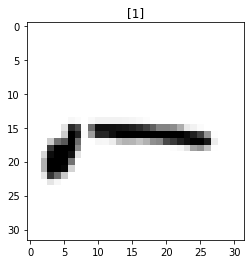

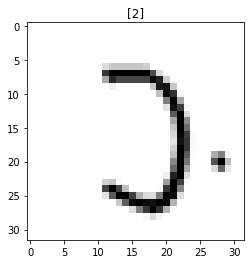

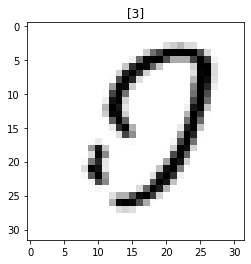

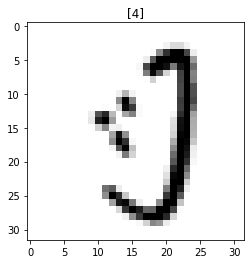

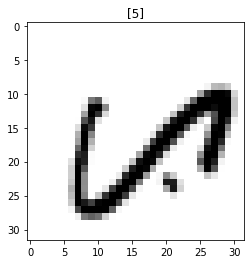

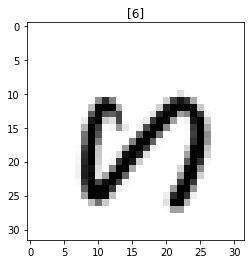

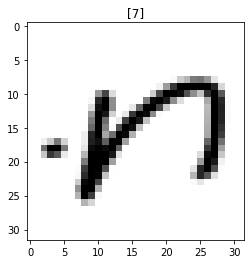

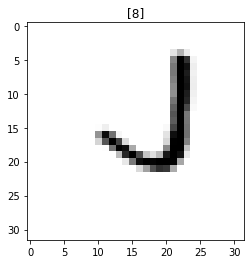

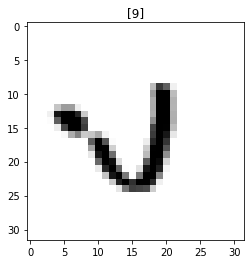

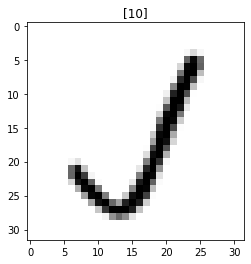

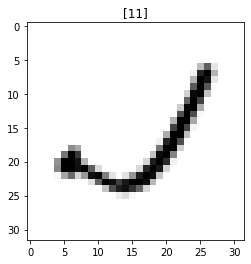

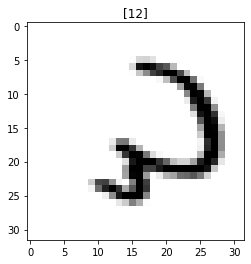

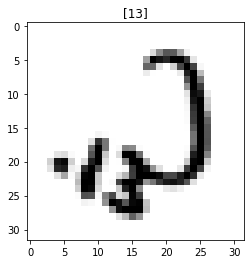

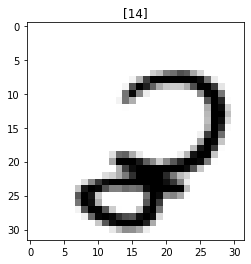

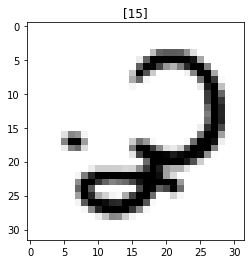

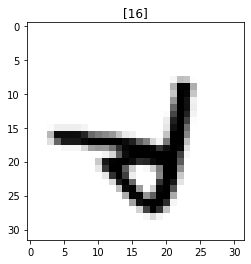

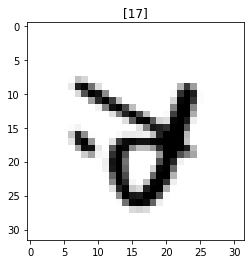

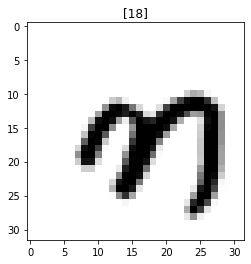

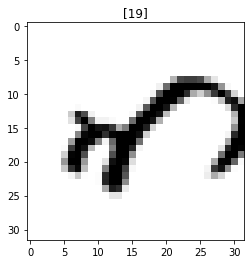

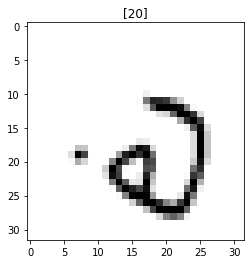

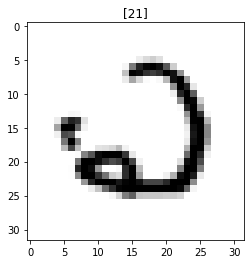

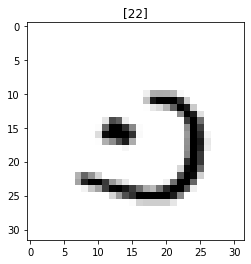

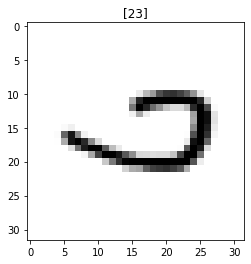

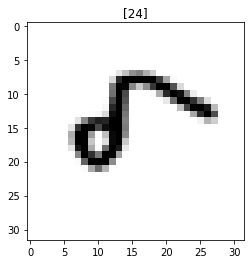

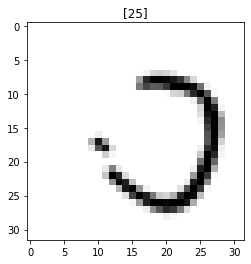

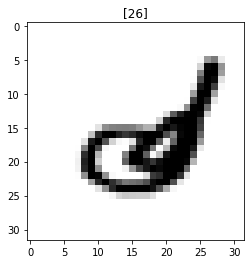

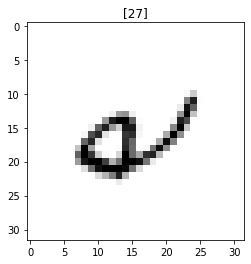

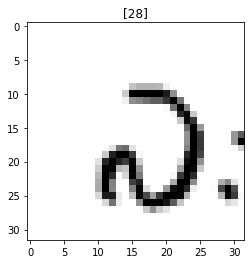

In [6]:
for i in range(28):
  plt.title(train_l.values[i*8+1])
  plt.imshow(traini[i*8+1], cmap='binary')
  plt.show()

**Maximum and Minimum values of the pixels**

In [7]:
print(f'max={traini.max()}')
print(f'min={traini.min()}')

max=255
min=0


**keep the 16th first classes**

In [8]:
indexNames = train_l[ train_l.values > 16 ].index
train_l.drop(indexNames , inplace=True)
train_i.drop(indexNames , inplace=True)

In [9]:
indexNames1 = test_l[ test_l.values > 16 ].index
test_l.drop(indexNames1 , inplace=True)
test_i.drop(indexNames1 , inplace=True)

**Count of the data in each classes**

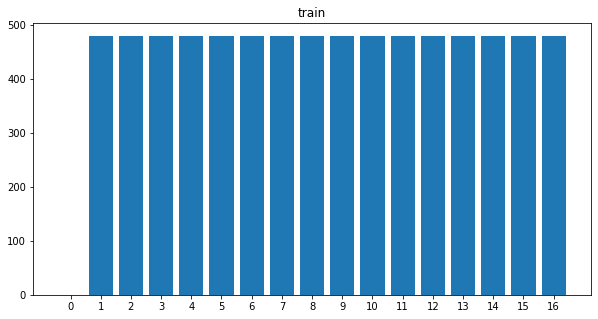

In [10]:
plt.figure(figsize=(10, 5))
classes = {}

for i in range(17):
    classes[i] = train_l[train_l.values == i].shape[0]

values = list(classes.values())
keys = list(classes.keys())
plt.title('train')
plt.bar(range(len(keys)), values, align='center')
plt.xticks(range(len(keys)))
plt.show()

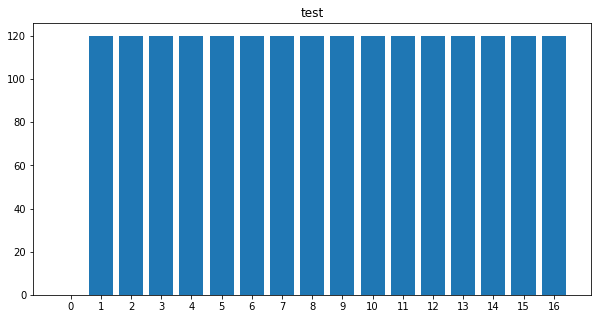

In [11]:
plt.figure(figsize=(10, 5))
classes = {}

for i in range(17):
    classes[i] = test_l[test_l.values == i].shape[0]

values = list(classes.values())
keys = list(classes.keys())
plt.title('test')
plt.bar(range(len(keys)), values, align='center')
plt.xticks(range(len(keys)))
plt.show()

**Normalizing data**

If we don't do this step, our features would lose their impacts moving forward and the activation functions would be obsolete.

In [12]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_i)
train_scaled = min_max_scaler.transform(train_i)
print(f'max={train_scaled.max()}')
print(f'min={train_scaled.min()}')

max=1.0
min=0.0


In [13]:
min_max_scaler.fit(test_i)
test_scaled = min_max_scaler.transform(test_i)
print(f'max={test_scaled.max()}')
print(f'min={test_scaled.min()}')

max=1.0
min=0.0


our last lyer can have one noron.in this case the value of this noron is the label of the class.then the output of the loss function would be different for the data with larg labels.
so we implement the last lyer with n norons where the n is the number of our classes. in this case the output of the right noron would be 1 and others 0. 
so we have to use one-hot-encoding for our lables.

In [ ]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical

#train_l = to_categorical(train_l)
#test_l = to_categorical(test_l)

# Dataloader

In [14]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        labels = labels.astype(int)
        onehot_vectors = np.zeros((labels.size, n_classes))
        onehot_vectors[np.arange(labels.size), labels] = 1.0
        return onehot_vectors
    
    def __shuffle_dataset(self):
        total_data = np.c_[
            self.__data.reshape(len(self.__data), -1), self.__onehot_labels.reshape(len(self.__onehot_labels), -1)]
        np.random.shuffle(total_data)
        data = total_data[:, :self.__data.size // len(self.__data)].reshape(self.__data.shape)
        self.__onehot_labels = total_data[:, self.__data.sizelen(self.__data):].reshape(self.__onehot_labels.shape)
        self.__data = data
        
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [15]:
class Identical:
    
    def __init__(self):
        pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self):
        pass
    
    def __val(self, matrix):
        relu_value = matrix.copy()
        relu_value[relu_value < 0] = 0
        return relu_value

    def derivative(self, matrix):
        relu_derivative = matrix.copy()
        relu_derivative[relu_derivative < 0] = 0
        relu_derivative[relu_derivative > 0] = 1
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leacky_relu_value = matrix.copy()
        leacky_relu_value = np.where(leacky_relu_value > 0, leacky_relu_value, 0.01 * leacky_relu_value)  
        return leacky_relu_value

    def derivative(self, matrix):
        leacky_relu_derivative = matrix.copy()
        leacky_relu_derivative = np.where(leacky_relu_derivative > 0, 1, 0.01) 
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self):
        pass

    def __val(self, matrix):
    
        sigmoid_value = 1.0 / (1.0 + np.exp(-matrix))
        return sigmoid_value

    def derivative(self, matrix):
        
        sigmoid_value = self.__val(matrix)
        sigmoid_derivative = np.multiply(sigmoid_value, 1 - sigmoid_value)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        
        return self.__val(matrix)


class Softmax:
        
    def __init__(self):
        pass

    def __val(self, matrix):
       
        softmax_value = np.zeros(matrix.shape)
        for i in range(0, len(matrix)):
            softmax_value[i] = np.exp(matrix[i] - np.max(matrix[i])) #stable softmax
            softmax_value[i] /= np.sum(softmax_value[i])
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self):
        pass

    def __val(self, matrix):
        tanh_value = np.tanh(matrix)
        return tanh_value

    def derivative(self, matrix):
        tanh_value = self.__val(matrix)
        tanh_derivative = 1 - np.multiply(tanh_value, tanh_value)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [16]:
BIAS = 1e-10
class CrossEntropy: #(with softmax)
    def __init__(self):
        pass

    def __val(self, true_val, expected_val):
        
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        cross_entropy_value = np.sum(-np.multiply(expected_val, np.log(softmax(true_val + BIAS) + BIAS)), axis=1)
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        cross_entropy_derivative = softmax(true_val) - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [17]:
class Layer:
   
    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)

        self.__last_input = layer_input.copy()
        
        self.__last_activation_input = np.add(np.dot(layer_input, self.__weight), self.__bias)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        backprop_tensor_copy = backprop_tensor.copy()
        dL_dy = np.multiply(backprop_tensor_copy, self.__last_activation_derivative)
        backprop_tensor = np.dot(dL_dy, self.__weight.transpose()) #dL_dx
        
        dL_dW = np.dot(self.__last_input.T, dL_dy)
        self.__weight -= (lr * dL_dW)
        
        ones_ = np.ones((1, dL_dy.shape[0]))
        dL_db = np.dot(ones_, dL_dy)
        self.__bias -= (lr * dL_db)
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']

        weights = np.random.uniform(low = low, high = high, size = (dim1, dim2))
        
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        
        weights = np.random.normal(loc = mean, scale = np.sqrt(var), size=(dim1, dim2))
        
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [18]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
    
        network_output = network_input.copy()
        for layer in self.__layers_list:
            network_output = layer.forward(network_output)
            
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
            
        return np.mean(batch_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        batch_out = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(batch_out, y_batch)
        batch_average_loss = np.mean(self.__loss(batch_out, y_batch))
        self.__update_weights(batch_out, y_batch)
        
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        batch_out = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(batch_out, y_batch)
        batch_average_loss = np.mean(self.__loss(batch_out, y_batch))
        
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        labels = outputs.argmax(axis=1)
        
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        generated_l = self.__get_labels(output)
        true_l = self.__get_labels(expected_output)
        accuracy = ((generated_l == true_l).sum() / output.shape[0]) 
        
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        gradiant = self.__loss.derivative(output, y_train)
        for layer in reversed(self.__layers_list):
            gradiant = layer.update_weights(gradiant, self.__lr)
            
        return

# Training Sample Code

In [2]:
# Sample code for building and training a model

columns_ = [i for i in range(0, 1024)]

train_rows = [np.reshape(row, 1024) for row in train_i.values]
train_neurons = pd.DataFrame(train_rows, columns=columns_)
test_rows = [np.reshape(row, 1024) for row in test_i.values]
test_neurons = pd.DataFrame(test_rows, columns=columns_)

INPUT_SHAPE = 1024
LEARNING_RATE = 0.005
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 32 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 32 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

NameError: ignored

**What if all the initial weights were zero?**

If all the weights are initialized to zeros, the derivatives will remain same for every w in W[l]. As a result, neurons will learn same features in each iterations. This problem is known as network failing to break symmetry. On a more general note, if we initialize the weights with a constant, all of our nodes will end up with the same value and it will be no different than having just one node in the hidden layer. Because of this, our network would end up learning just one function while the goal of a neural network is to have different nodes compute different functions. To avoid such problem, we can initialize the weights randomly.

**What impact does the learning rate play?**

We know that learning rate has a direct relation with the value of our change. However, we need to find the proper learning rate such that our accuracy will be maximum. Here, we run our code for two (very) different learning rates.

In [ ]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.0001
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 32 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 32 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

We can see that we're not taking as big steps as we should and therefore are moving very slowly (especially at the beginning). Our highest accuracy is around 60 percent.

In [ ]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.1
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 32 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 32 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

This time, our steps are bigger than we needed so we can't actually improve the accuracy and miss the desired spot at each epoch.


In [ ]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.005
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 32 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 32 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

In [ ]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.005
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 32 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 32 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Tanh(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

We can see that neither Sigmoid nor Tanh have a acceptable performance.

Sigmoid has two main disadvantages:


1.   Sigmoids saturate and kill gradients: A very undesirable property of the sigmoid neuron is that when the neuron's activation saturates at either tail of 0 or 1, the gradient at these regions is almost zero. Therefore, if the local gradient is very small, no signal will flow through the neuron to its weights and recursively to its data. Additionally, one must pay extra caution when initializing the weights of sigmoid neurons to prevent saturation. For example, if the initial weights are too large then most neurons would become saturated and the network will barely learn.
2.   Sigmoid outputs are not zero-centered: This is undesirable since neurons in later layers of processing in a Neural Network would be receiving data that is not zero-centered. This has implications on the dynamics during gradient descent, because if the data coming into a neuron is always positive, then the gradient on the weights w will during backpropagation become either all be positive, or all negative (depending on the gradient of the whole expression f). This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights.

Tanh saturates too. Large values snap to 1.0 and small values snap to -1 for tanh. Further, the function is only really sensitive to changes around its mid-point of the input (e.g. 0.0).

Layers deep in large networks using these nonlinear activation functions fail to receive useful gradient information. Error is back propagated through the network and used to update the weights. The amount of error decreases dramatically with each additional layer through which it is propagated, given the derivative of the chosen activation function. This is called the vanishing gradient problem and prevents deep (multi-layered) networks from learning effectively.

Note that tanh tanh is preferred and usually performs better than sigmoid (logistic) becuase it's symmetric about the origin, where the inputs would be normalized and they are more likely to produce outputs (which are inputs to next layer) and also, they are on an average close to zero. It can also be said that data is centered around zero for tanh.







In [ ]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.005
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 32 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 32 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

We can see that LeakyRelu is working similar to Relu. In theory, it should be wroking a bit better, especially when we have a lot of negative values. Remember that in Relu, when we face a negative value during backpropagation, because of the fact that the derivative is 0, no learning happens and the weights remain the same. However with LeakyRelu we no longer face a 0 derivative and can learn even from the negative values.

In [ ]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.005
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 16 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 16 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

In [ ]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.005
EPOCHS = 100

TRAINLOADER = Dataloader(data = train_neurons, labels = train_l.values, n_classes = 16, batch_size = 256 , shuffle=False)
TESTLOADER =  Dataloader(data = test_neurons, labels = test_l.values, n_classes = 16, batch_size = 256 , shuffle=False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)
log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

As it can be seen, batch size = 16 has a higher accuracy. This is because larger batches do fewer and coarser search steps for the optimal solution, and so by construction will be less likely to converge on the optimal solution.

Using larger batch sizes would allow us to parallelize computations to a greater degree, since we could split up the training examples between different worker nodes. This in turn could significantly speed up model training. However, larger batch sizes, while able to achieve similar training error as smaller batch sizes, tend to generalize worse to test data.

Generally, we can conclude that the larger the batch size:

*   The slower the training loss decreases.
*   The higher the minimum validation loss.
*   The less time it takes to train per epoch.
*   The more epochs it takes to converge to the minimum validation loss.

The main reason to use batches in training is because of the fact that we don't have infinite memory. By using batches, we can divide the program's memory into different parts. Also, if we don't use batches, we would need to store thousands of error values in the memory and this will decrease our training speed. On the other hand, say our batch size is 32, then we only need to store the error values for 32 neurons.

Using mini-batches has its own pros and cons.

**Pros:**

*   The model update frequency is higher than batch gradient descent which allows for a more robust convergence, avoiding local minima.
*   The batched updates provide a computationally more efficient process than stochastic gradient descent.
*   The batching allows both the efficiency of not having all training data in memory and algorithm implementations.

**Cons:**

*   Mini-batch requires the configuration of an additional “mini-batch size” hyperparameter for the learning algorithm.
*   Error information must be accumulated across mini-batches of training examples like batch gradient descent.
